In [7]:
import logging
import pandas as pd
from sklearn.linear_model import LinearRegression
import wandb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import os,sys,yaml
import requests

module_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

if module_path not in sys.path:
    sys.path.append(module_path)
# Now you can import your module
from src.DataOps.feature_engg import feature_engg_class
from src.ModelOps.model_fit import ModelFit
from src.DataOps.feature_engg import feature_engg_class
import numpy as np
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
#load NASA_API_KEY from .env file
import os
from dotenv import load_dotenv
load_dotenv()
ALPHA_VANTAGE_API_KEY=os.getenv("ALPHA_VANTAGE_API_KEY")

In [3]:
import requests
import json
from tqdm import tqdm


def request_stock_price_hist(symbol, token, sample = False):
    if sample == False:
        q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol={}&outputsize=full&apikey={}'
    else:
        q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol={}&apikey={}'

    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 6))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Weekly Adjusted Time Series'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Weekly Adjusted Time Series'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "adjusted close", "volume", "dividend amount"]
    df['date'] = date
    df = df.set_index('date')
    return df


In [27]:
data=request_stock_price_hist('IBM', ALPHA_VANTAGE_API_KEY)

Retrieving stock price data from Alpha Vantage (This may take a while)...
Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 1278/1278 [00:01<00:00, 795.89it/s]


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1278 entries, 2024-05-03 to 1999-11-12
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   open             1278 non-null   object
 1   high             1278 non-null   object
 2   low              1278 non-null   object
 3   close            1278 non-null   object
 4   adjusted close   1278 non-null   object
 5   volume           1278 non-null   object
 6   dividend amount  1278 non-null   object
dtypes: object(7)
memory usage: 79.9+ KB


In [29]:
#convert all columns to numeric
data = data.apply(pd.to_numeric, errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1278 entries, 2024-05-03 to 1999-11-12
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             1278 non-null   float64
 1   high             1278 non-null   float64
 2   low              1278 non-null   float64
 3   close            1278 non-null   float64
 4   adjusted close   1278 non-null   float64
 5   volume           1278 non-null   int64  
 6   dividend amount  1278 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 79.9+ KB


In [30]:
#sort the data by date in ascending order
data = data.sort_index(ascending=True)

<Axes: xlabel='date'>

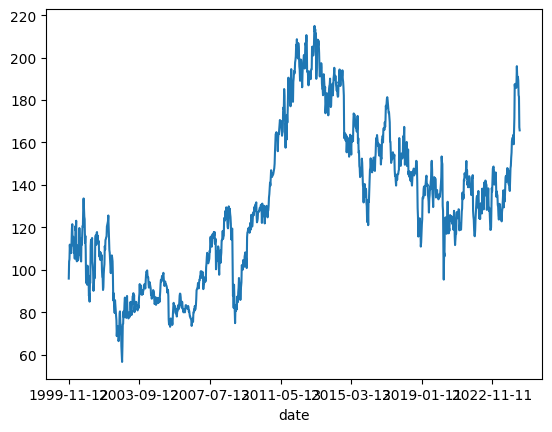

In [31]:
 #plot the close column 
data['close'].plot()

### Train- Test Split


In [32]:
logging.info("Data loaded successfully")
df=data[['close']].copy()
#overall shape of the data
df.shape

INFO:root:Data loaded successfully


(1278, 1)

In [33]:
#print out the first and the last index
df.index[0], df.index[-1]

('1999-11-12', '2024-05-03')

### Linear Regression


In [34]:
!pip install fastai


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [35]:
from fastai.tabular.core import add_datepart
#reset index
df.reset_index(inplace=True)
print(df.head())


         date   close
0  1999-11-12   95.87
1  1999-11-19  103.94
2  1999-11-26  105.00
3  1999-12-03  111.87
4  1999-12-10  109.00


In [36]:
add_datepart(df, 'date')

/Users/sakshamgulati/.local/share/virtualenvs/MLOps_Template-k_6XISXV/lib/python3.10/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


,close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,95.87,1999,11,45,12,4,316,False,False,False,False,False,False,9.423648e+08
1,103.94,1999,11,46,19,4,323,False,False,False,False,False,False,9.429696e+08
2,105.00,1999,11,47,26,4,330,False,False,False,False,False,False,9.435744e+08
3,111.87,1999,12,48,3,4,337,False,False,False,False,False,False,9.441792e+08
4,109.00,1999,12,49,10,4,344,False,False,False,False,False,False,9.447840e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,189.14,2024,4,14,5,4,96,False,False,False,False,False,False,1.712275e+09
1274,182.27,2024,4,15,12,4,103,False,False,False,False,False,False,1.712880e+09
1275,181.58,2024,4,16,19,4,110,False,False,False,False,False,False,1.713485e+09
1276,167.13,2024,4,17,26,4,117,False,False,False,False,False,False,1.714090e+09


In [39]:
train=df[:int(0.7*df.shape[0])]
test=df[int(0.7*df.shape[0]):]
logging.info("Data split into train and test successfully")
logging.info(f"Train shape: {train.shape[0]}")
logging.info(f"Test shape: {test.shape[0]}")

x_train = train.drop(['close'], axis=1)
y_train = train['close']
x_test = test.drop(['close'], axis=1)
y_test = test['close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

INFO:root:Data split into train and test successfully
INFO:root:Train shape: 894
INFO:root:Test shape: 384


LinearRegression()

In [40]:
preds = model.predict(x_test)
rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rms

66.88902982996775

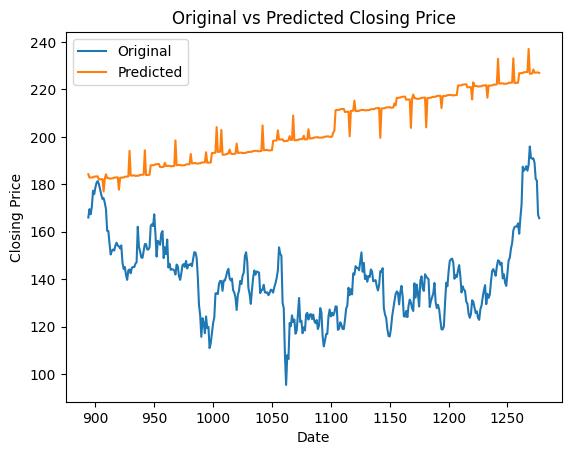

In [47]:
#plot the predictions with the original values
import matplotlib.pyplot as plt

# Plotting the original values
plt.plot(test.index, test['close'], label='Original')

# Plotting the predicted values
plt.plot(test.index, preds, label='Predicted')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Original vs Predicted Closing Price')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


### Prophet

In [50]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached Cython-3.0.10-py2.py3-none-any.whl.metadata (3.2 kB)
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.9.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached holidays-0.47-py3-none-any.whl.metadata (23 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.0 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
  Using cached pystan-3.9.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached pystan-3.8.0-py3-none-an

In [48]:
from fbprophet import Prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 47.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 23.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 4.3 MB/s eta 0:00:00
   ━━

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
df_prophet=df.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)
train=df[:int(0.7*df_prophet.shape[0])]
test=df[int(0.7*df_prophet.shape[0]):]

In [ ]:
model = Prophet()
model.fit(train)
close_prices = model.make_future_dataframe(periods=len(test))
forecast = model.predict(close_prices)